# Práctica 3: Visualización de Mapas

Por Eduardo Graells-Garrido (Barcelona Supercomputing Center, <eduardo.graells@bsc.es>).

#### Objetivo

En este notebook trabajaremos con información geográfica. Seguiremos estudiando el data set de viajes de la encuesta origen-destino, esta vez enfocándonos en distintos patrones geográficos que puedan ayudarnos a responder preguntas específicas.


#### Preámbulo y Carga de Datos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# incorporamos geopandas! geografía + pandas :)
import geopandas as gpd
from sklearn.preprocessing import normalize

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# esto configura la apariencia de los gráficos: tamaños de letra, bordes, colores base, etc.
sns.set(context='paper', font='Fira Code', style='ticks', palette='colorblind', font_scale=1.1)

In [3]:
from aves.data import DATA_PATH
from aves.data import eod
from aves.features.utils import normalize_rows

In [4]:
zones = gpd.read_file(DATA_PATH / 'processed/scl_zonas_urbanas.json').set_index('ID')
zones.head()

AREA   Zona    Com     Comuna REGION  \
ID                                              
103  837.7500  103.0  13105  El Bosque     13   
104  998.8125  104.0  13105  El Bosque     13   
106  286.2500  106.0  13105  El Bosque     13   
115  857.4375  115.0  13105  El Bosque     13   
116  853.9375  116.0  13105  El Bosque     13   

                           NOM_REGION PROVINCIA NOM_PROVIN NOM_COMUNA  \
ID                                                                      
103  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  EL BOSQUE   
104  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  EL BOSQUE   
106  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  EL BOSQUE   
115  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  EL BOSQUE   
116  REGIÓN METROPOLITANA DE SANTIAGO       131   SANTIAGO  EL BOSQUE   

        URBANO             TIPO NOM_CATEG  SHAPE_Leng  SHAPE_Area  \
ID                                                                  
103  EL BOSQUE  CAPITAL COMUNAL    CIUDAD    0.152123    0.001391   
104  EL BOSQUE  CAPITAL COMUNAL    CIUDAD    0.152123    0.001391   
106  EL BOSQUE  CAPITAL COMUNAL    CIUDAD    0.152123    0.001391   
115  EL BOSQUE  CAPITAL COMUNAL    CIUDAD    0.152123    0.001391   
116  EL BOSQUE  CAPITAL COMUNAL    CIUDAD    0.152123    0.001391   

                                              geometry  
ID                                                      
103  POLYGON ((-70.65485 -33.55436, -70.65497 -33.5...  
104  POLYGON ((-70.67891 -33.55911, -70.67767 -33.5...  
106  POLYGON ((-70.67599 -33.55542, -70.67767 -33.5...  
115  POLYGON ((-70.67599 -33.55542, -70.67602 -33.5...  
116  POLYGON ((-70.66819 -33.55207, -70.66701 -33.5...

In [5]:
viajes = eod.read_trips()

# descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
viajes = viajes[(viajes['SectorOrigen'] != 'Exterior a RM') 
                & (viajes['SectorDestino'] != 'Exterior a RM')
                & (viajes['SectorOrigen'] != 'Extensión Sur-Poniente') 
                & (viajes['SectorDestino'] != 'Extensión Sur-Poniente')
                & pd.notnull(viajes['SectorOrigen'])
                & pd.notnull(viajes['SectorDestino'])
                # también descartamos viajes que hayan sido imputados en la encuesta
                & (viajes['Imputada'] == 0)
                # y finalmente descartamos viajes cuya distancia indique que son viajes cortísimos o bien demasiado largos para el tamaño de la ciudad
                & (viajes['DistManhattan'].between(500, 35000))]

print(len(viajes))

77288


In [6]:
personas = eod.read_people()

viajes_persona = viajes.merge(personas)

Calculamos el factor de expansión de cada viaje:

In [7]:
viajes_persona['PesoLaboral'] = viajes_persona['FactorLaboralNormal'] * viajes_persona['Factor_LaboralNormal']

In [8]:
viajes_persona = viajes_persona[pd.notnull(viajes_persona['PesoLaboral'])]
len(viajes_persona)

54230

Así, el total de viajes que tenemos para un día laboral es:

In [9]:
print('{} viajes expandidos a {}'.format(len(viajes_persona), int(viajes_persona['PesoLaboral'].sum())))

54230 viajes expandidos a 12127185


En este punto, ya tenemos dos elementos que podemos utilizar para definir tareas:

- La tabla de viajes, cruzada con la tabla de personas.
- Geografía de Santiago utilizando la misma unidad de análisis espacial: zonas EOD.

Definamos _tareas_ o _preguntas a responder_ con estos datos.

---

## 1. ¿Cuál es la distribución geográfica de los viajes al trabajo de acuerdo al modo de transporte?

Para responder esta pregunta consideremos lo siguiente:

- Nos interesa particularmente el _origen_ de los viajes. Por ej., esperaríamos que una comuna más periférica tuviese viajes con más combinaciones que una comuna céntrica. La tabla de viajes contiene las columnas `OrigenCoordX` y `OrigenCoordY` que nos permitirán analizar este punto.
- Nos interesa el patrón geográfico de la distribución. Por tanto, necesitamos un mapa.

¿Cómo lucen las coordenadas?

In [10]:
viajes_persona[['OrigenCoordX', 'OrigenCoordY']].head()

OrigenCoordX  OrigenCoordY
0   335208.7188     6288387.0
1   338812.2813     6292391.0
2   338536.4375     6291928.0
3   354267.3438     6302297.0
4   338536.4375     6291928.0

Si bien las coordenadas están en formato numérico, no sabemos en qué sistema de coordenadas están, ni tampoco las tenemos estructuradas en un `GeoDataFrame`. Para ello, usaremos la función `to_point_geodataframe` de `geopandas` para darle contexto geográfico a los datos. 

In [11]:
from aves.features.geo import to_point_geodataframe

<AxesSubplot:>

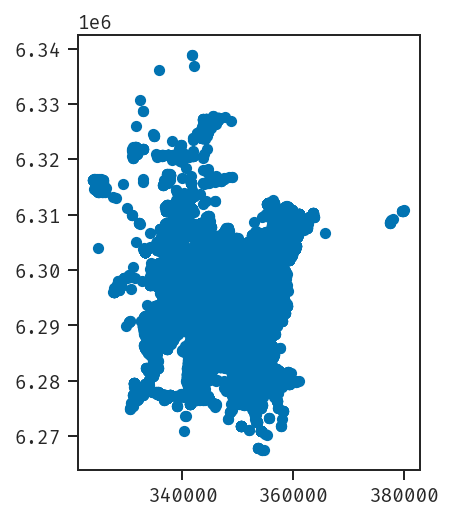

In [12]:
origenes_viajes = to_point_geodataframe(viajes_persona, 'OrigenCoordX', 'OrigenCoordY', crs='epsg:32719')
origenes_viajes.plot()

In [13]:
origenes_viajes = gpd.GeoDataFrame(viajes_persona,
                                   geometry=gpd.points_from_xy(viajes_persona['OrigenCoordX'], viajes_persona['OrigenCoordY']),
                                   crs='EPSG:32719').to_crs(zones.crs)
print(len(origenes_viajes))
origenes_viajes.head()

54230


Hogar   Persona       Viaje  Etapas ComunaOrigen ComunaDestino  \
0  173431  17343102  1734310202       1        Maipú         Maipú   
1  173431  17343102  1734310201       1        Maipú         Maipú   
2  173441  17344101  1734410101       2        Maipú    Las Condes   
3  173441  17344101  1734410102       2   Las Condes         Maipú   
4  173441  17344103  1734410301       2        Maipú         Ñuñoa   

  SectorOrigen SectorDestino  ZonaOrigen  ZonaDestino  ...  TramoIngresoFinal  \
0     Poniente      Poniente         400          407  ...                  0   
1     Poniente      Poniente         407          400  ...                  0   
2     Poniente       Oriente         407          307  ...                  2   
3      Oriente      Poniente         307          407  ...                  2   
4     Poniente       Oriente         407          437  ...                  2   

   IngresoImputado  Factor_LaboralNormal  Factor_SabadoNormal  \
0                0              142.3375                  NaN   
1                0              142.3375                  NaN   
2                0              112.9581                  NaN   
3                0              112.9581                  NaN   
4                1              103.5267                  NaN   

  Factor_DomingoNormal  Factor_LaboralEstival Factor_FindesemanaEstival  \
0                  NaN                    NaN                       NaN   
1                  NaN                    NaN                       NaN   
2                  NaN                    NaN                       NaN   
3                  NaN                    NaN                       NaN   
4                  NaN                    NaN                       NaN   

  FactorPersona PesoLaboral                     geometry  
0      53.39174  142.337500  POINT (-70.77467 -33.53142)  
1      53.39174  142.337500  POINT (-70.73515 -33.49587)  
2      46.32137  127.328613  POINT (-70.73820 -33.50001)  
3      46.32137  127.328613  POINT (-70.56723 -33.40878)  
4      43.02566  116.697351  POINT (-70.73820 -33.50001)  

[5 rows x 78 columns]

Grafiquemos los orígenes de los viajes en conjunto con las zonas:

In [14]:
from aves.visualization.figures import figure_from_geodataframe, tighten_figure

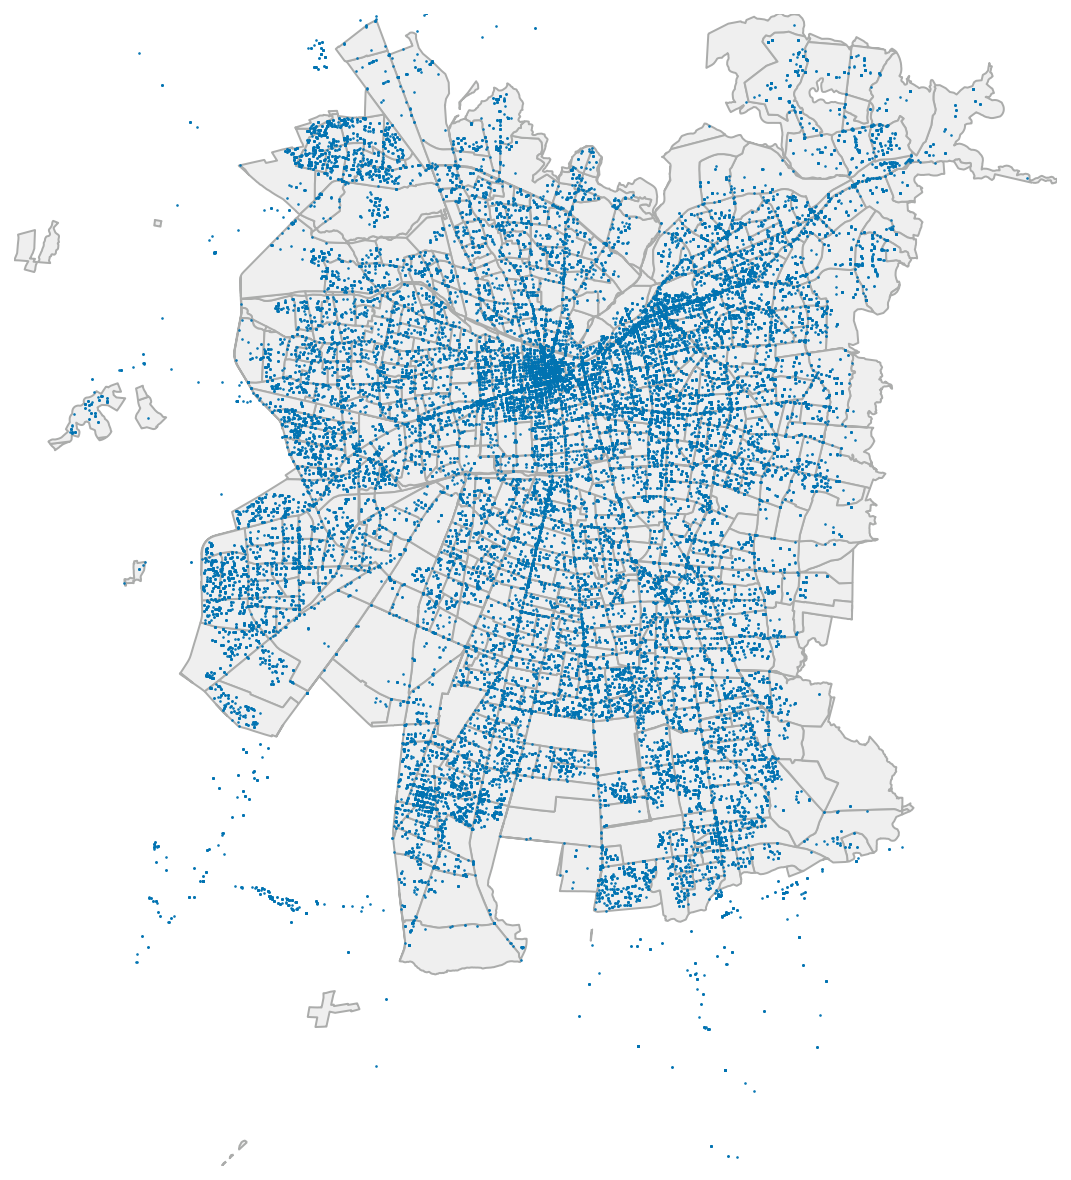

In [15]:
fig, ax = figure_from_geodataframe(zones, height=8, remove_axes=True)

zones.plot(ax=ax, color='#efefef', edgecolor='#abacab', linewidth=1)
origenes_viajes.plot(ax=ax, markersize=1, marker='.')

tighten_figure(fig)

Vemos que hay viajes en sectores que no son relevantes para el análisis que queremos realizar, ya que están fuera del contexto urbano. Para seguir avanzando utilizaremos la operación _spatial join_ de `geopandas`, en el método `sjoin`. Un _spatial join_ cruza dos data sets desde una perspectiva espacial, a través de una operación definida. En nuestro caso, queremos los orígenes de viajes que estén dentro de las zonas urbanas. Esa operación en inglés es `within`. Se ejecuta de la siguiente manera:

In [16]:
# nota: asegurarse que ambos GeoDataFrames tienen el mismo sistema de referencia
# los parámetros lsuffix y rsuffix indican el sufijo a agregar a las columnas de cada tabla
origenes_urbanos = gpd.sjoin(origenes_viajes, 
                            zones, 
                            op='within', lsuffix='_l', rsuffix='_r')
print(len(origenes_urbanos))

52253


Grafiquemos los orígenes de viajes urbanos al trabajo.

In [17]:
origenes_urbanos.ModoDifusion.value_counts()

Bip!                    21944
Auto                    14665
Caminata                 6260
Otros                    3538
Taxi Colectivo           1609
Bicicleta                1558
Taxi                     1019
Bip! - Otros Público     1006
Bip! - Otros Privado      654
Name: ModoDifusion, dtype: int64

/home/egraells/resources/aves/src/aves/visualization/maps.py:6: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


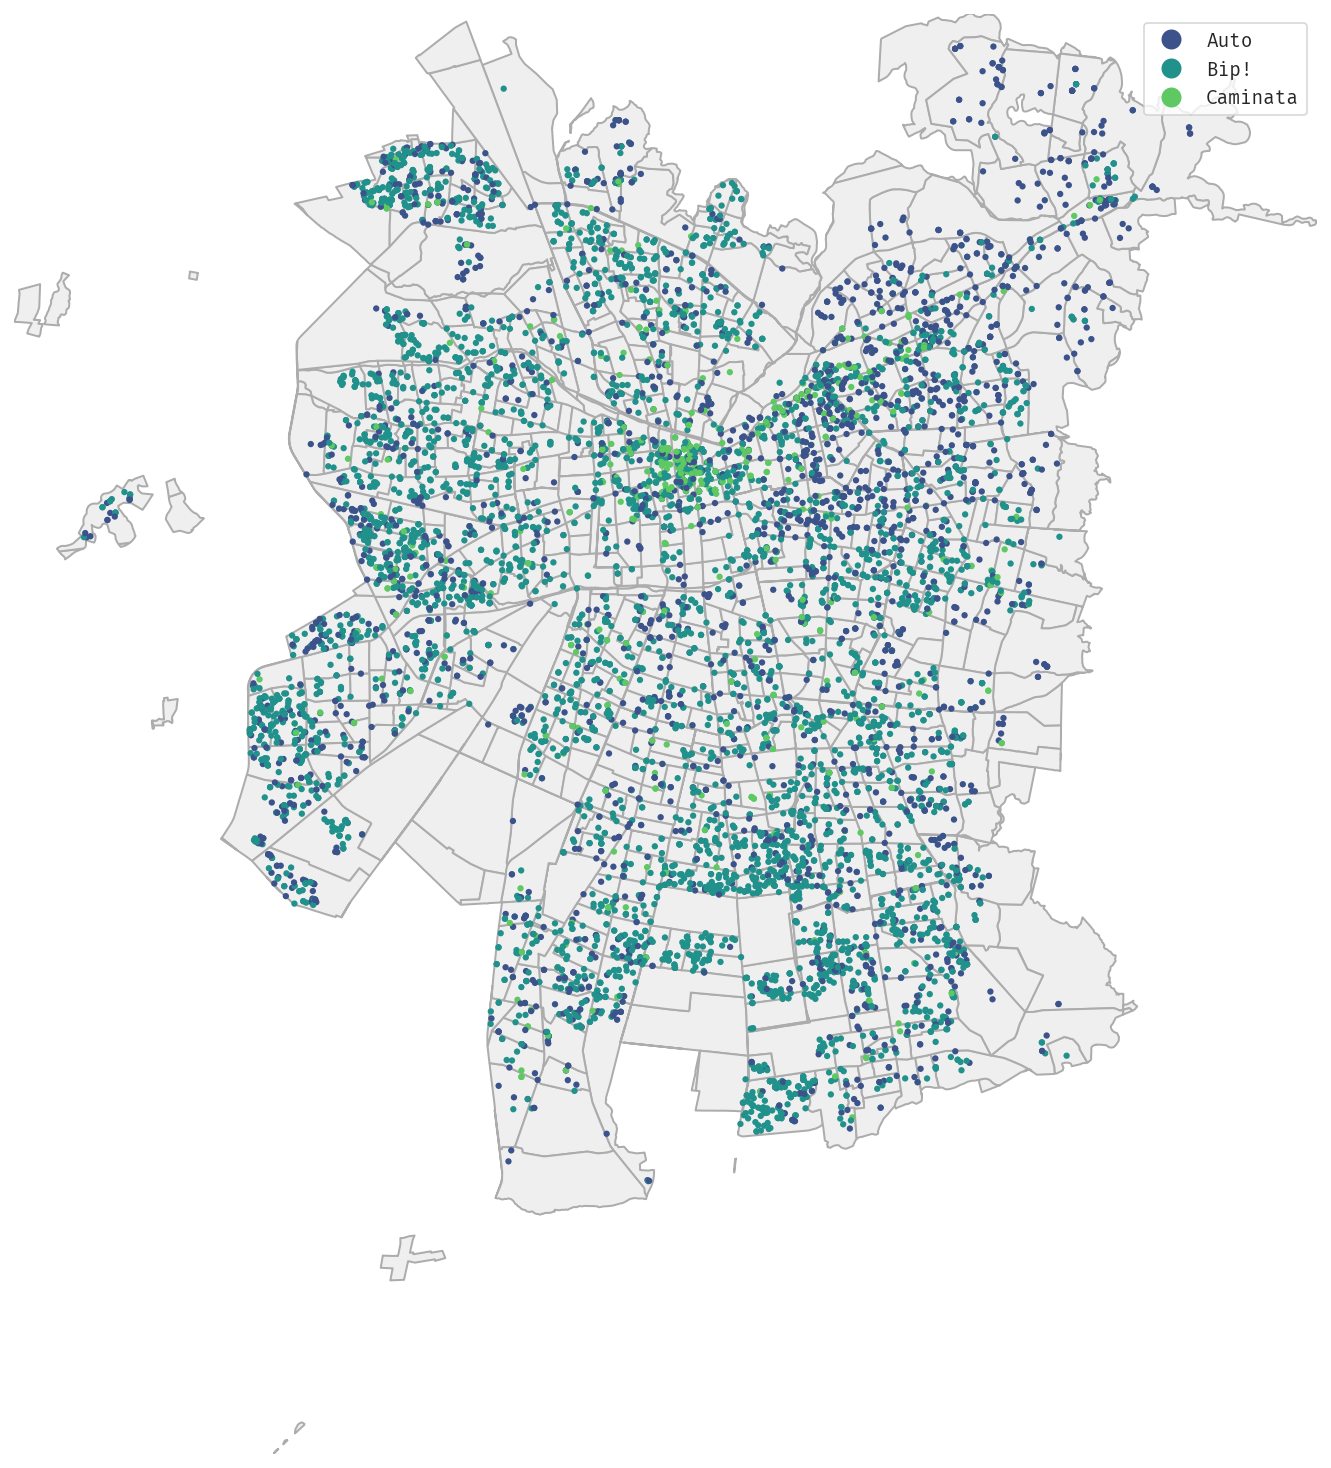

In [18]:
from aves.visualization.maps import dot_map

fig, ax = figure_from_geodataframe(zones, height=10, remove_axes=True)

zones.plot(ax=ax, color='#efefef', edgecolor='#abacab', linewidth=1)

origenes_a_graficar = origenes_urbanos[(origenes_urbanos.Proposito == 'Al trabajo') &
                                       (origenes_urbanos.ModoDifusion.isin(['Bip!', 'Auto', 'Caminata']))]

dot_map(ax, origenes_a_graficar, category='ModoDifusion', size=10, palette='viridis')

tighten_figure(fig)

A pesar de que estamos usando una paleta de colores que permite identificar el número de etapas de cada viaje, en el mapa cuesta ver una posible distribución geográfica debido a la oclusión y aglomeramiento de los viajes.

Una posible solución es darle un tamaño a cada punto que sea proporcional al peso de los viajes. Utilizaremos la función `minmax_scale` de `scikit-learn` para hacerlo:

In [19]:
from sklearn.preprocessing import minmax_scale
origenes_urbanos['PesoVisual'] = minmax_scale(origenes_urbanos['PesoLaboral'], (0.01, 1.0))
origenes_urbanos['PesoVisual'].describe()

count    52253.000000
mean         0.071504
std          0.069135
min          0.010000
25%          0.028845
50%          0.046460
75%          0.087564
max          1.000000
Name: PesoVisual, dtype: float64

El peso visual mínimo de un viaje es $0.01$; el máximo, $1.00$ (son los parámetros que le entregamos a la función).
Esto hará que sea directo escalar los tamaños de los puntos. 

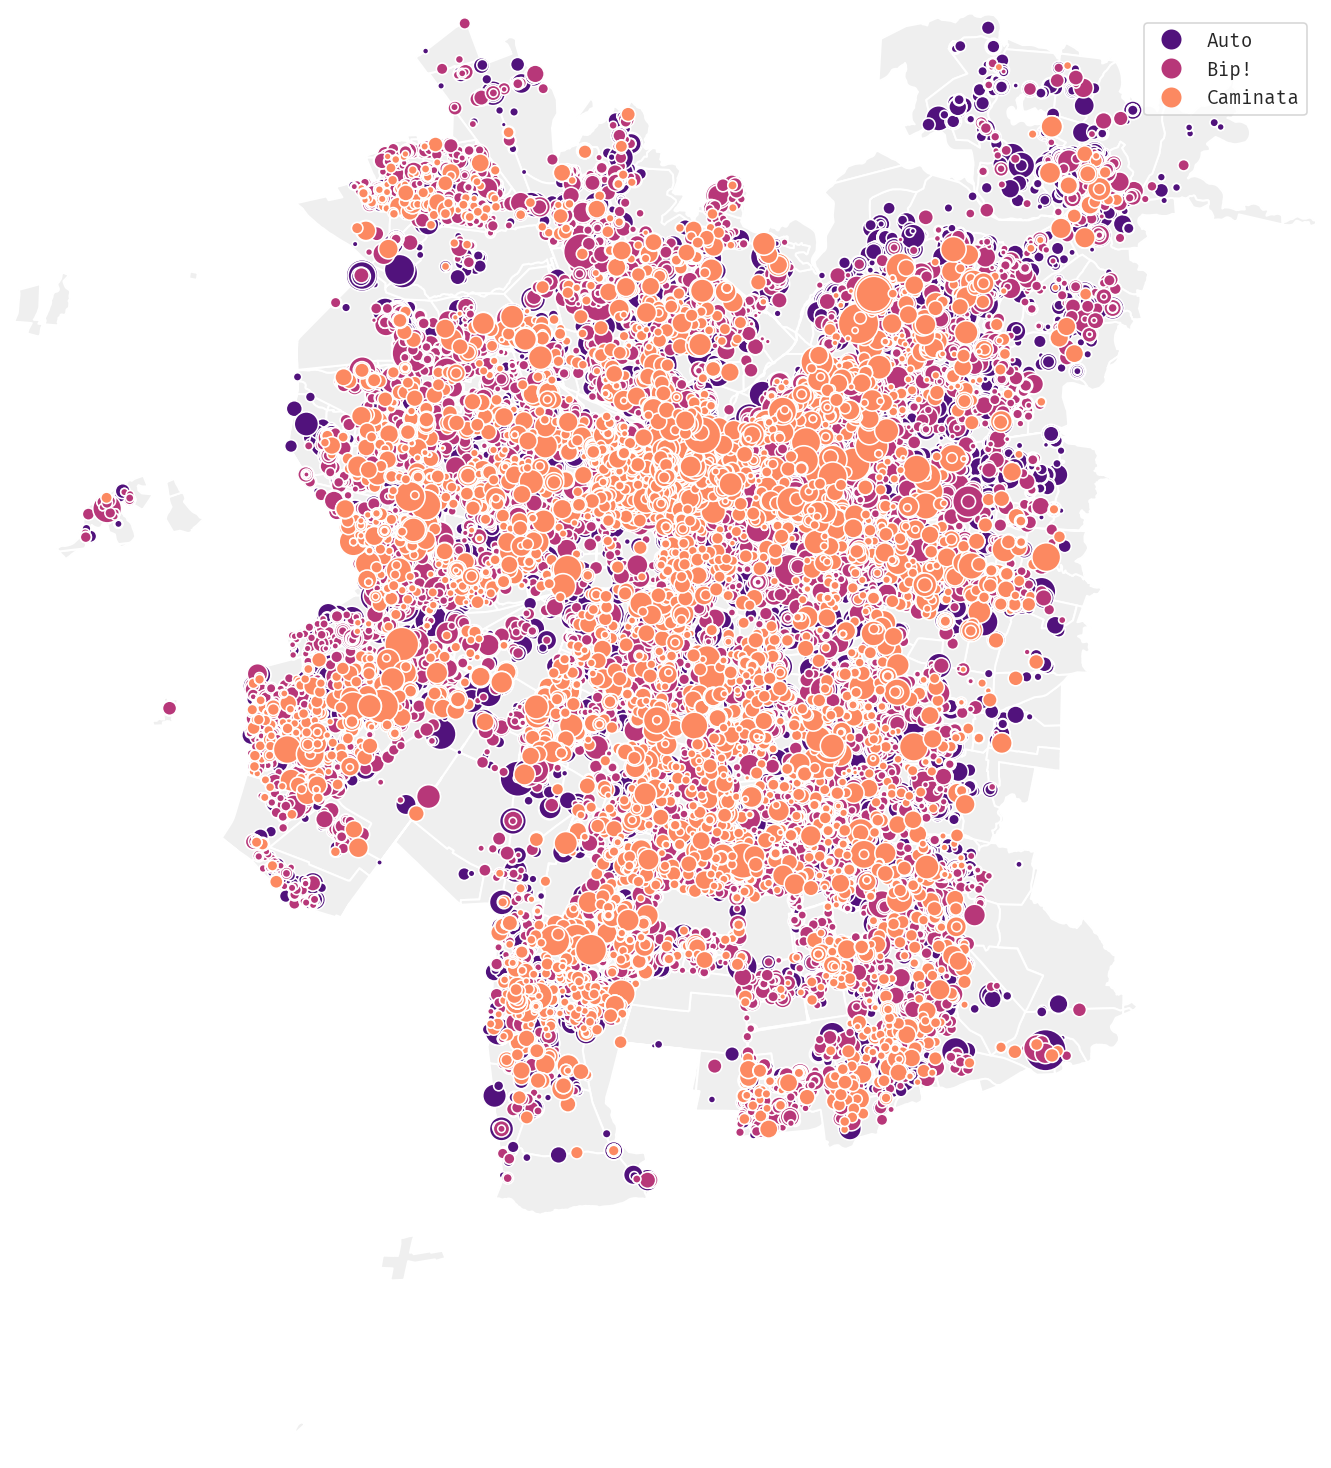

In [20]:
from aves.visualization.maps import bubble_map

fig, ax = figure_from_geodataframe(zones, height=10, remove_axes=True)

zones.plot(ax=ax, color='#efefef', edgecolor='white', linewidth=1)

bubble_map(ax, origenes_urbanos[origenes_urbanos.ModoDifusion.isin(['Bip!', 'Auto', 'Caminata'])], 
           category='ModoDifusion', size='PesoVisual', scale=500, sort_categories=True, palette='magma')

tighten_figure(fig)

La idea sonaba bien, sin embargo, el gráfico no nos permite responder la pregunta (aunque es un lindo gráfico para compartir y contemplar). Esto se debe a varios factores, incluyendo la interferencia entre los canales utilizados en la codificación.

Una solución es utilizar múltiples gráficos, uno para cada valor de la categoría que nos interesa:

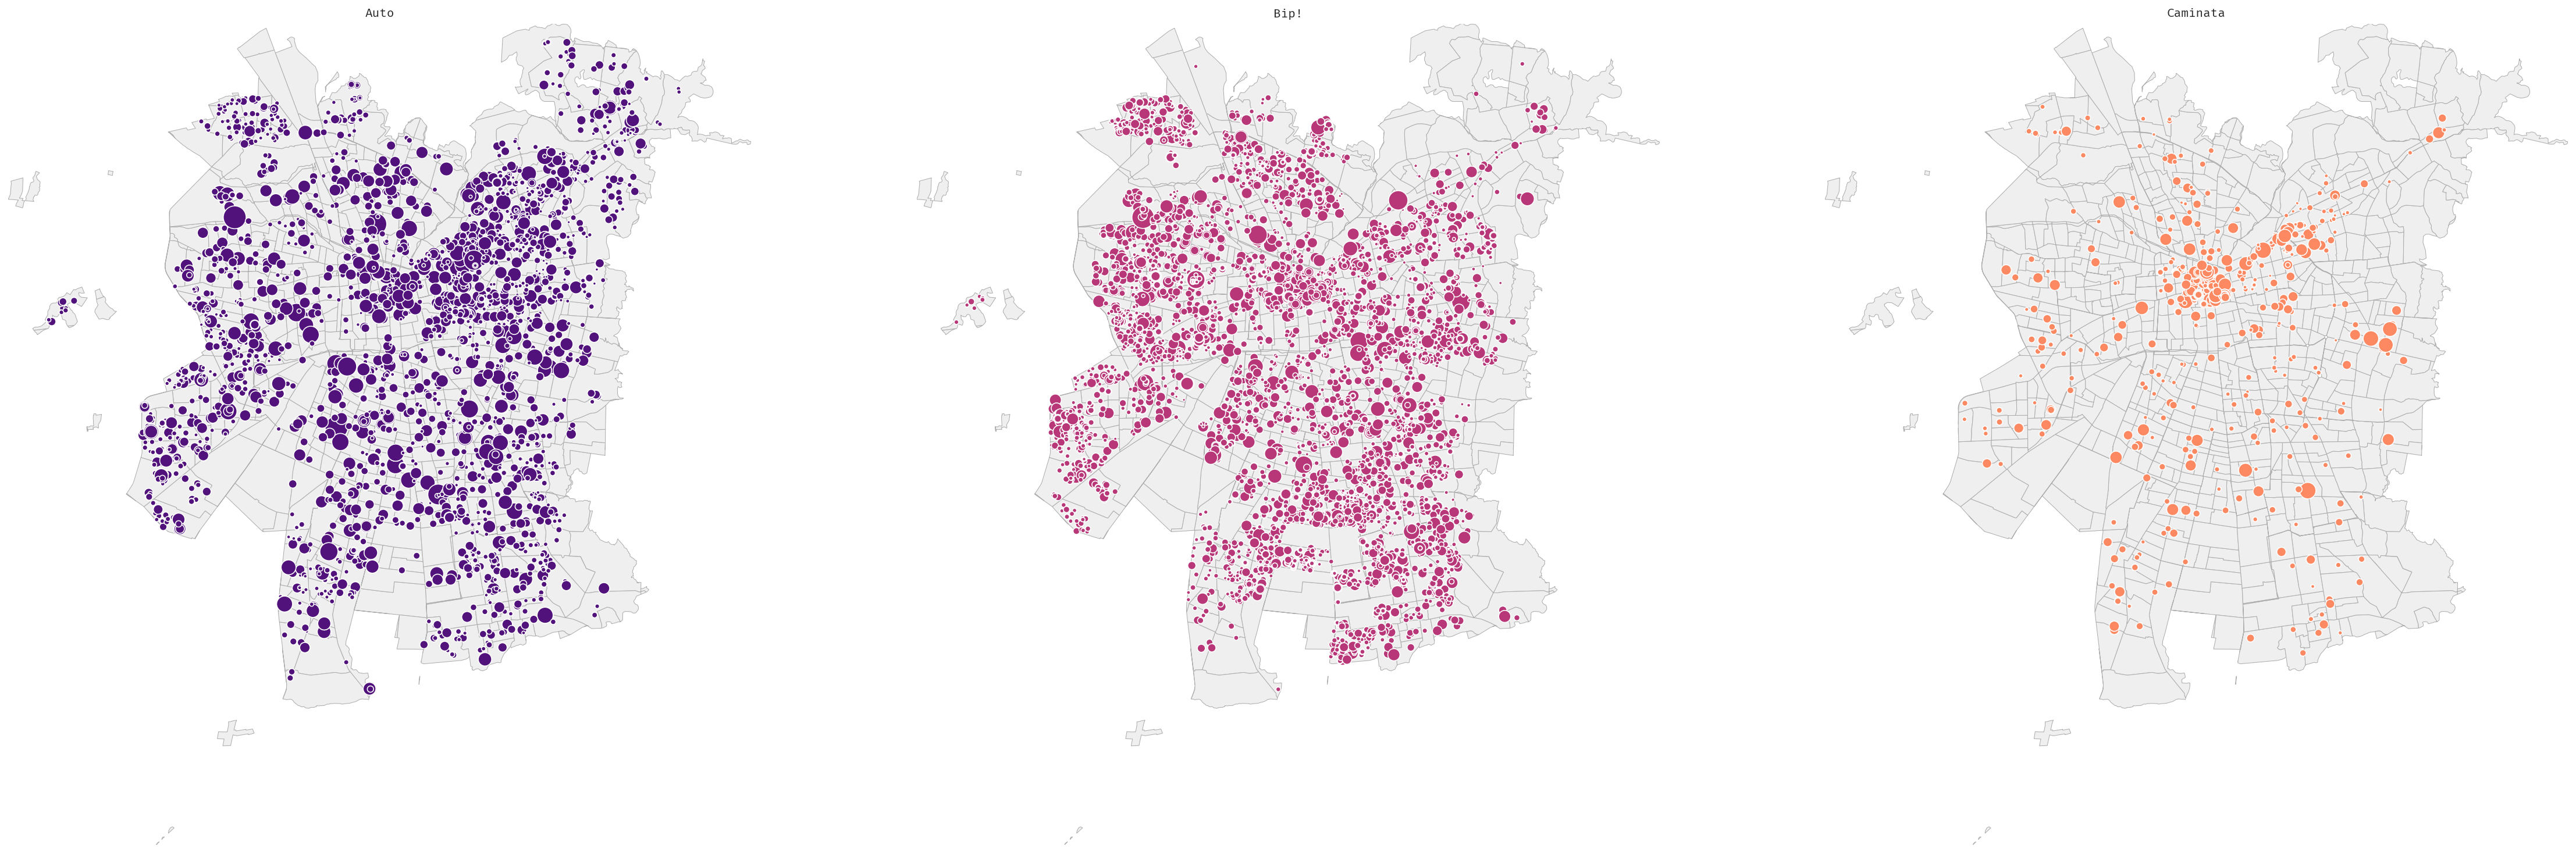

In [21]:
from aves.visualization.figures import small_multiples_from_geodataframe

fig, axes = small_multiples_from_geodataframe(zones, 3, height=10, col_wrap=3, remove_axes=True)

colors = sns.color_palette('magma', n_colors=3)

# el método zip nos permite iterar sobre dos listas simultáneamente
for ax, modo, color in zip(axes, ['Auto', 'Bip!', 'Caminata'], colors):
    zones.plot(ax=ax, color='#efefef', edgecolor='#abacab', linewidth=0.5)
    ax.set_title(modo)
      
    origenes_a_graficar = origenes_urbanos[(origenes_urbanos.Proposito == 'Al trabajo') &
                                           (origenes_urbanos.ModoDifusion == modo)]
    
    bubble_map(ax, origenes_a_graficar, size='PesoVisual', scale=500, sort_categories=True, color=color)    
    
tighten_figure(fig)

Sin embargo, la sobreposición de los puntos es un problema. En el caso de 1 etapa de viaje, no logramos ver la distribución debido a la oclusión de los puntos.

La solución es usar un `heat_map`

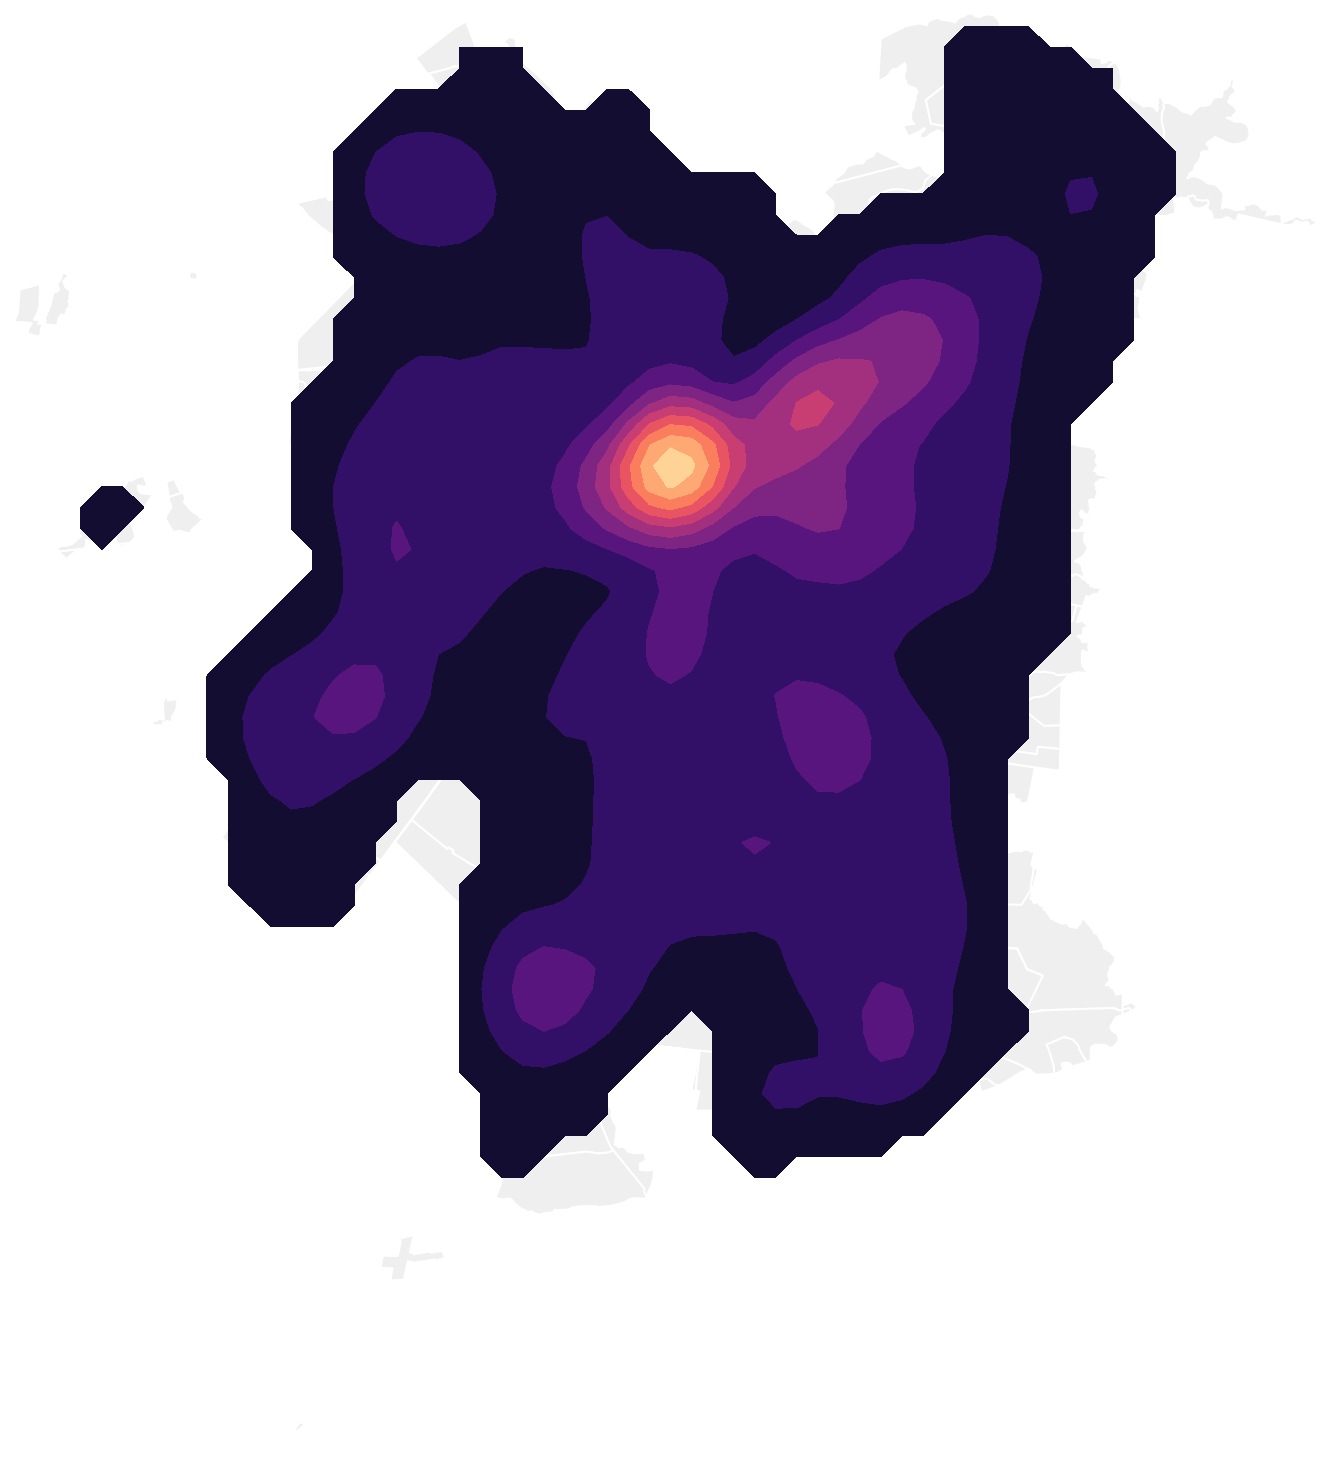

In [22]:
from aves.visualization.maps import heat_map

fig, ax = figure_from_geodataframe(zones, height=10, remove_axes=True)

zones.plot(ax=ax, color='#efefef', edgecolor='white', linewidth=1)

heat_map(ax, origenes_urbanos, min_value=1, n_levels=10, weight_column='PesoLaboral')

tighten_figure(fig)

Ahora sí nos estamos entendiendo :)

Hagamos el gráfico por modo de transporte:

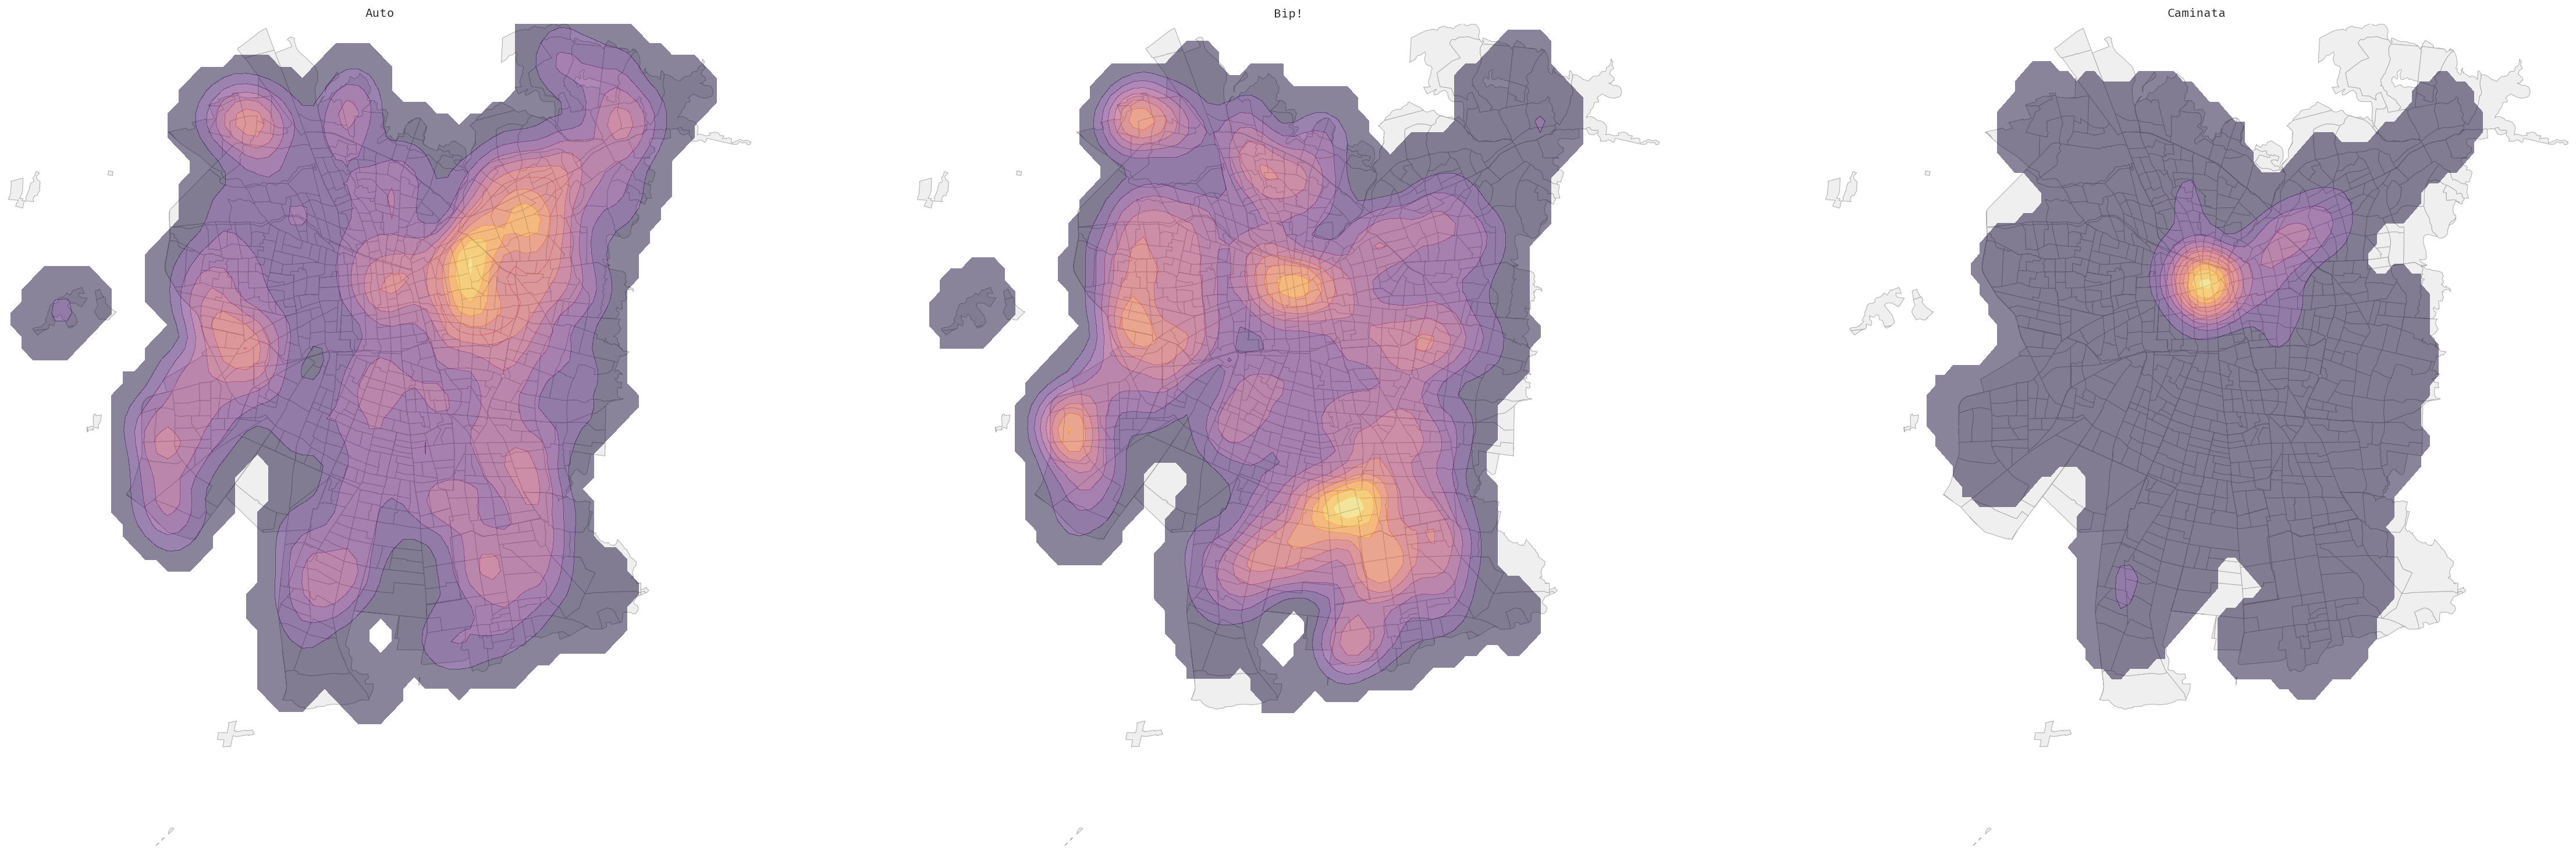

In [23]:
fig, axes = small_multiples_from_geodataframe(zones, 3, height=10, col_wrap=3, remove_axes=True)

for ax, modo in zip(axes, ['Auto', 'Bip!', 'Caminata']):
    zones.plot(ax=ax, color='#efefef', edgecolor='#abacab', linewidth=0.5)
    ax.set_title(modo)
      
    origenes_a_graficar = origenes_urbanos[(origenes_urbanos.Proposito == 'Al trabajo') &
                                           (origenes_urbanos.ModoDifusion == modo)]
    
    heat_map(ax, origenes_a_graficar, min_value=0.1, n_levels=10, alpha=0.5, weight_column='PesoLaboral', palette='inferno')
    
tighten_figure(fig)

Lo que queda pendiente es decidir cuándo utilizar una leyenda de colores. Lo veremos en una próxima clase.

---

## 2. ¿Cuán lejos queda el trabajo de acuerdo al lugar de residencia?

Con esta pregunta queremos entender si existe un patrón geográfico en las elecciones de residencia y trabajo de las personas.

Para responder la pregunta, primero filtramos los viajes que nos interesan:

In [24]:
viajes_trabajo = viajes_persona[(viajes_persona.Proposito == 'Al trabajo') &
                                (pd.notnull(viajes_persona.PesoLaboral))]
print(len(viajes_trabajo), viajes_trabajo.PesoLaboral.sum())

10692 2334845.965121292


Observamos que, si bien son 11642 filas en la tabla, representan a más de 1.7 millones de viajes.

La columna `DistEuclidiana` contiene la distancia entre los puntos de origen y destino de los viajes.

> **Nota**: no todos los viajes al trabajo se efectúan desde la casa, ni una persona hace un único viaje al trabajo durante el día.Pero omitiremos eso por el momento.

Veamos la distribución de la distancia:

In [25]:
viajes_trabajo['DistEuclidiana'].describe()

count    10692.000000
mean      8918.699401
std       6371.268964
min        355.000000
25%       3529.000000
50%       7621.500000
75%      13347.500000
max      33539.000000
Name: DistEuclidiana, dtype: float64

Ahora bien, el promedio que nos entregó el método `pd.describe` no considera la representatividad de cada viaje. Podemos escribir una función que, dada una columna, calcula su representatividad, definiéndola como un promedio ponderado:

In [26]:
from aves.features.weights import weighted_mean
viajes_trabajo['DistEuclidiana'].mean(), weighted_mean(viajes_trabajo, 'DistEuclidiana', 'PesoLaboral')

(8918.699401421623, 8447.391300853487)

En este caso, el promedio ponderado no está lejos del promedio sin ponderar, pero nada asegura que esa diferencia sea pequeña para todas las variables.

Podemos calcular la distancia promedio al trabajo por zona haciendo una operación `pd.groupby`:

In [27]:
distancia_zonas = (viajes_trabajo
                   .groupby(['ZonaOrigen'])
                   .apply(lambda x: weighted_mean(x, 'DistEuclidiana', 'PesoLaboral'))
                   .rename('distancia_al_trabajo')
)
distancia_zonas

ZonaOrigen
1       6368.733791
2       5952.584070
3       7476.621070
4       4731.477408
5      10901.184351
           ...     
798    10481.323392
799     8598.123555
800     4329.383595
801    14431.040329
803    15296.390919
Name: distancia_al_trabajo, Length: 713, dtype: float64

La variable `distancia_zonas` es una `Serie` de `pandas`. Cada columna de un `DataFrame` es una serie. Para poder hacer operaciones con ella, como cruzarla con un `DataFrame` a través del método `join`, necesita un nombre. Lo podemos asignar así:

La serie contiene, para cada zona, la distancia promedio al trabajo de la gente que vive en ella (y posiblemente otras más). Si queremos ver esta distribución podemos utilizar el método `plot(kind='kde')`, como hicimos en notebooks anteriores:

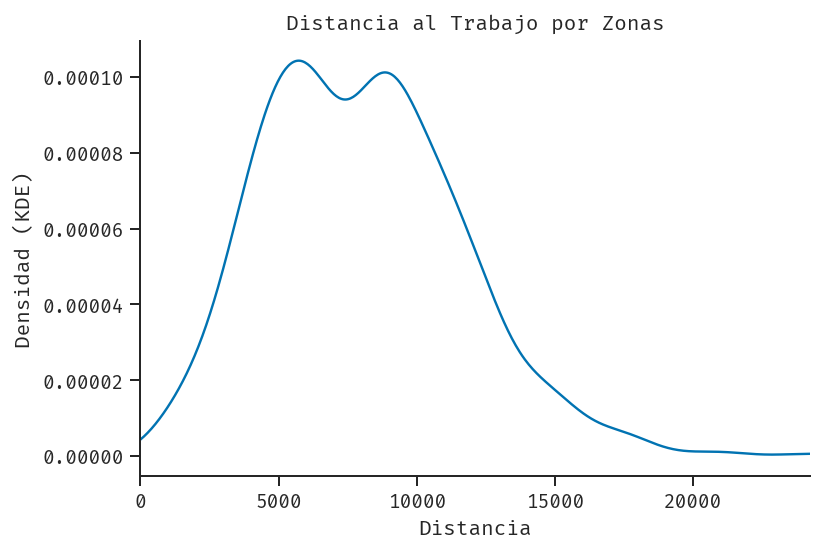

In [28]:
distancia_zonas.plot(kind='kde')
plt.xlim([0, distancia_zonas.max()])
plt.title('Distancia al Trabajo por Zonas')
plt.xlabel('Distancia')
plt.ylabel('Densidad (KDE)')
sns.despine()

Ahora bien, esta distribución solamente nos permite saber propiedades estádisticas. ¡No tenemos un contexto geográfico! Por eso necesitamos el mapa, para saber si la distancia tiene relación con la ubicación de cada zona en la ciudad, con saber si zonas que están cerca entre sí tienen distancias al trabajo similares.

Como tenemos los valores de distancia por zona, un _choropleth map_ nos permitiría mostrar la distancia asociada a cada zona al mismo tiempo que su posición geográfica. 

In [29]:
from aves.visualization.maps import choropleth_map

/home/egraells/resources/aves/src/aves/visualization/figures.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=0, h_pad=0, w_pad=0)


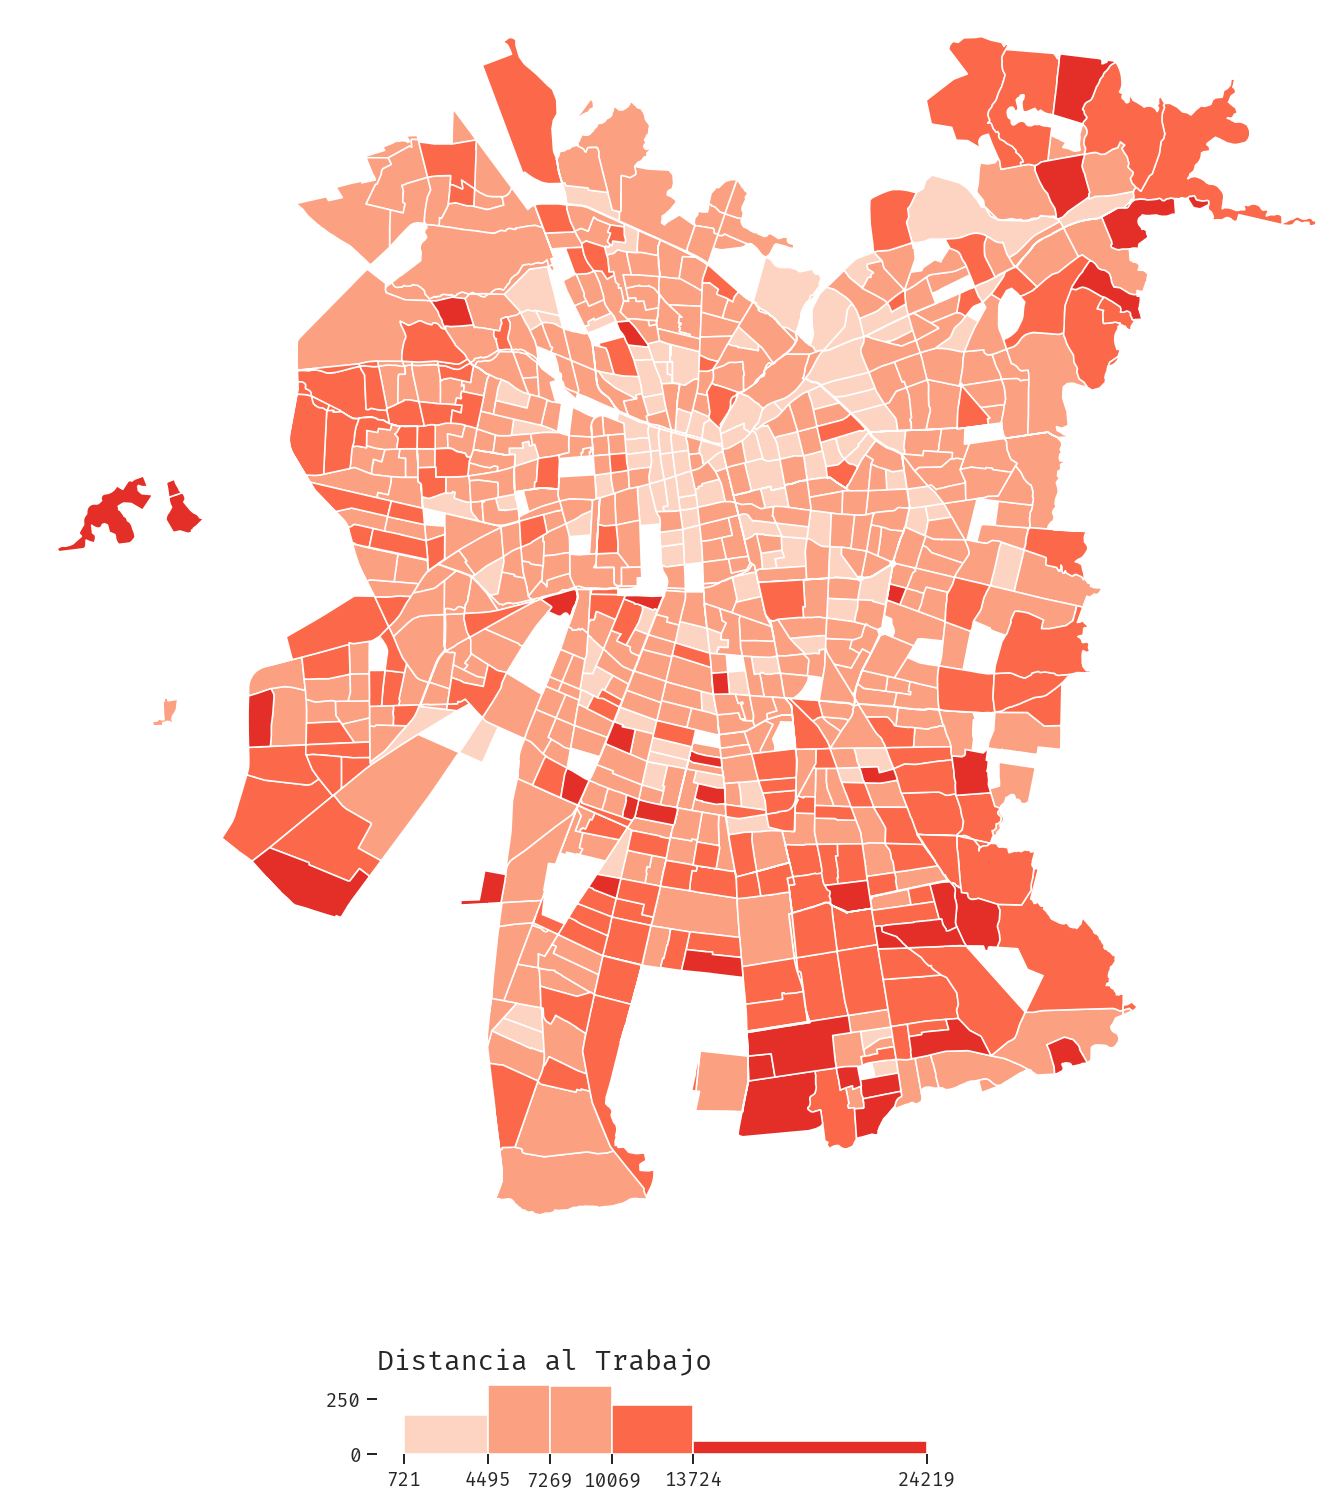

In [30]:
fig, ax = figure_from_geodataframe(zones, height=10, remove_axes=True)

ax, cax = choropleth_map(ax, zones.join(distancia_zonas, how='inner'), 'distancia_al_trabajo', 
                         k=5, legend_type='hist', fisher_jenks=True,
                         cbar_location='lower center', cbar_height=0.5, cbar_width=4)
cax.set_title('Distancia al Trabajo', fontsize=14, loc='left')
tighten_figure(fig)

La leyenda explica que valores más claros (es decir, los primeros quintiles) tienen menores distancias al trabajo. Al mismo tiempo, observamos la concentración de los trabajos en la ciudad: las zonas más claras tienden a aparecer en Santiago, Providencia, Las Condes, y sus alrededores. Como consecuencia, las zonas periféricas tienen una distancia al trabajo mayor: casi toda la periferia está compuesta de zonas oscuras.

¿cómo se calculan los rangos que son representados por cada color? El parámetro `scheme='Quantiles'` y `k=5` explicitan eso: se calculan cinco percentiles. Pero, ¿son los percentiles lo más adecuado?

Existen otras alternativas. Una de ellas es utilizar el esquema llamado [_Natural Breaks_](https://en.wikipedia.org/wiki/Jenks_natural_breaks_optimization), que busca la mejor manera de clasificar datos en un número específico de categorías (una especie de clustering _K-Means_ en una dimensión). Lo podemos especificar en la función de dibujo con el parámetro `scheme='Fisher_Jenks'` ([se llama así porque lo inventó _Jenks_ y lo mejoró _Fisher_](http://wiki.objectvision.nl/index.php/Fisher's_Natural_Breaks_Classification)).

¿Cuál esquema les parece mejor (para una definición de mejor elegida por ustedes)?

¿Qué otro patrón observan en este mapa? ¿Qué más harían?

**¿Se imaginan este mapa mezclado con los mapas anteriores?** Ése es un ejercicio propuesto.

---

## Conclusiones

Como ven, en ocasiones existen visualizaciones de tablas que permiten estudiar datos con atributos geográficos, sin embargo, los mapas nos entregan una riqueza contextual que no solamente permite hacer preguntas más profundas, sino que al mismo tiempo incita a hacer más preguntas a los datos. 

En este notebook utilizamos `geopandas` para hacer _dot maps_, _heatmaps_ y _choropleth maps_. Existen técnicas más avanzadas que veremos más adelante, no siempre disponibles en Python. Sin embargo, eso no significa que no usemos `geopandas`. Por ejemplo, un flujo común de trabajo es hacer análisis en `geopandas`, y luego exportar en formato `shapefile` o `GeoJSON` para ser visualizado en una herramienta interactiva (como `QGIS` o `Kepler.gl`).